In [ ]:
#default_exp main

In [ ]:
#export
import os
import pandas as pd
import numpy as np
import transformers

from fastai.text.all import *
from sklearn.model_selection import StratifiedKFold

from Hasoc import utils
from Hasoc import model

In [ ]:
#export
SEED = 42
utils.seed_everything(seed=SEED)

In [ ]:
#export 
MODEL_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 72
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#export
df = pd.read_csv(os.path.join('../data', 'en_task_a', 'hasoc_2020_en_train_new.csv'), sep='\t')

In [ ]:
# #export
# df['kfold_task1'] = -1
# df['kfold_task2'] = -1
# df = df.sample(frac=1.,random_state=SEED).reset_index(drop=True)
# y = df['task1'].values
# kf = StratifiedKFold(n_splits=5)
# for fold,(t_,v_) in enumerate(kf.split(X=df,y=y)):
#     df.loc[v_,'kfold_task1'] = fold

# df = df.sample(frac=1.,random_state=SEED).reset_index(drop=True)
# y = df['task2'].values
# for fold,(t_,v_) in enumerate(kf.split(X=df,y=y)):
#     df.loc[v_,'kfold_task2'] = fold

In [ ]:
#hide
df.sample(2)

,tweet_id,text,task1,task2,ID
1783,1.123670e+18,BITCH WTF,HOF,PRFN,hasoc_2020_en_3456
1929,1.123805e+18,god dammit help bitch,HOF,PRFN,hasoc_2020_en_4942


In [ ]:
#hide
df['task1'].value_counts()

HOF    1856
NOT    1852
Name: task1, dtype: int64

In [ ]:
#hide
df['task2'].value_counts()

NONE    1852
PRFN    1377
OFFN     321
HATE     158
Name: task2, dtype: int64

In [ ]:
#export
df.tweet_id = df.tweet_id.astype('int').astype('str')

In [ ]:
df = df[:1000]

In [ ]:
#export
bert_tokenizer = transformers.BertTokenizer.from_pretrained(
            pretrained_model_name_or_path=MODEL_NAME,
            do_lower_case=True,
            )

In [ ]:
bert_vocab = bert_tokenizer.get_vocab()
bert2fastai_vocab = [k for k, v in sorted(bert_vocab.items(), key=lambda item: item[1])]

In [ ]:
#export 
pad = partial(pad_input_chunk, pad_first=False, pad_idx=bert_tokenizer.pad_token_id, seq_len=MAX_SEQ_LEN)

In [ ]:
#export
custom_tokenizer = Tokenizer.from_df(text_cols='text', tok=utils.HFTokenizer(tokenizer=bert_tokenizer), rules=[])

In [ ]:
#export
tfms = [attrgetter('text'), custom_tokenizer, Numericalize(vocab=bert2fastai_vocab), utils.Add_Special_Cls(tokenizer=bert_tokenizer)]

In [ ]:
# fold = 1
# splits = IndexSplitter(list(df.query(f'kfold_task1 == {fold}').index))(df)

In [ ]:
#export
splits = RandomSplitter()(df)

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task1'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ sud ##out ##ats ##uy ##a : eat shit grammar nazis ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! [SEP],HOF
1,[CLS] rt @ na ##lu _ for _ you : after na ##lu one of my favourite [UNK] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD],NOT


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], drop_mult=0.3, device=device, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.10000000149011612)

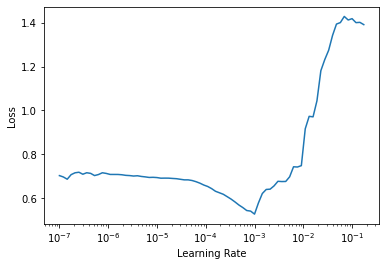

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 3e-4

learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.676453,0.461485,0.815000,0.811566,00:07
1,0.476758,0.278150,0.905000,0.904941,00:07
2,0.349545,0.359354,0.890000,0.889901,00:07
3,0.336503,0.338055,0.885000,0.884974,00:07
4,0.265382,0.419658,0.880000,0.880000,00:08
5,0.207189,0.431603,0.870000,0.869987,00:08
6,0.164889,0.438316,0.855000,0.854909,00:07


In [ ]:
#export
learn.export(os.path.join('models', 'task1.pkl'))

## Task2

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task2'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ sud ##out ##ats ##uy ##a : eat shit grammar nazis ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! [SEP],OFFN
1,[CLS] rt @ na ##lu _ for _ you : after na ##lu one of my favourite [UNK] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD],NONE


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

No weighting

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], drop_mult=0.3, device=device, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.737800812406931e-05)

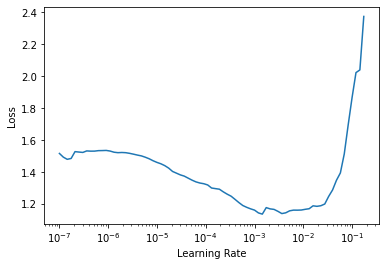

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 3e-4

learn.fit_one_cycle(5, lr, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.114770,0.672871,0.770000,0.405553,00:07
1,0.882834,0.648158,0.805000,0.425668,00:07
2,0.721153,0.596368,0.835000,0.445953,00:08
3,0.538478,0.767924,0.800000,0.448964,00:07
4,0.411191,0.688783,0.820000,0.531746,00:07


In [ ]:
#export
learn.export(os.path.join('models', 'task2.pkl'))

## interp

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

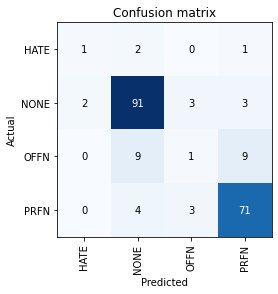

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.predict('What the fuck are you talking. go to hell')

('PRFN', tensor(3), tensor([1.9603e-03, 8.5831e-04, 8.3661e-03, 9.8882e-01]))

In [ ]:
learn.predict("I will chop off your head and kill you")

('HATE', tensor(0), tensor([0.6577, 0.1883, 0.0711, 0.0829]))